<a href="https://colab.research.google.com/github/impruthvi/Dog-Vision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-end Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them). 


In [2]:
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

In [3]:
# Run this cell if TensorFlow 2.x isn't default in colab
try:
  # %tensorflow_version only exist in Colab
  %tensorflow_version
except Exception:
  pass

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [4]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF Version",tf.__version__)
print("TF Hub Version",hub.__version__)

# Check for GTU availability

print("GPU","Available(Yesssss)" if tf.config.list_physical_devices("GPU") else "Not available")

TF Version 2.4.1
TF Hub Version 0.12.0
GPU Available(Yesssss)


## Getting our data ready(turning into Tensors)

Will all machine learning models, our data has be in numerical format.So that's what we'll be doing first.Truning our images into Tensor(numerical representations).

Let's start by accessing our data and checking out that labels.

In [5]:
# Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d63acb5d222016e636daaf98d6b2c810  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


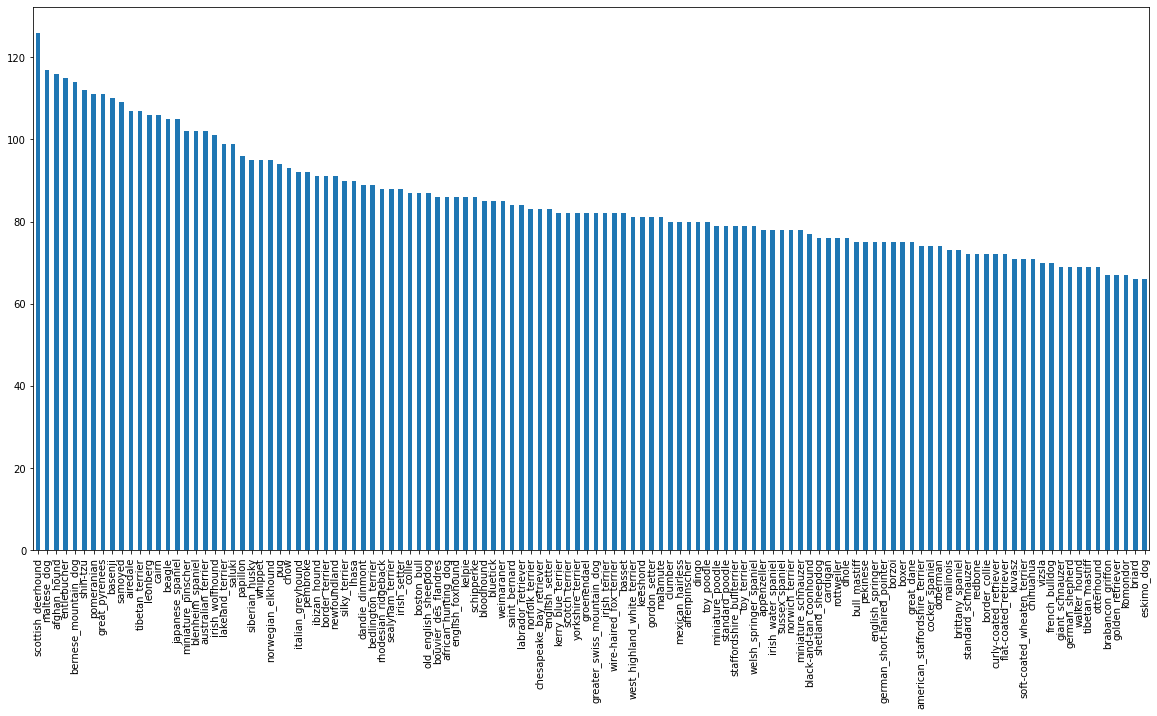

In [7]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [8]:
labels_csv['breed'].value_counts().median()

82.0

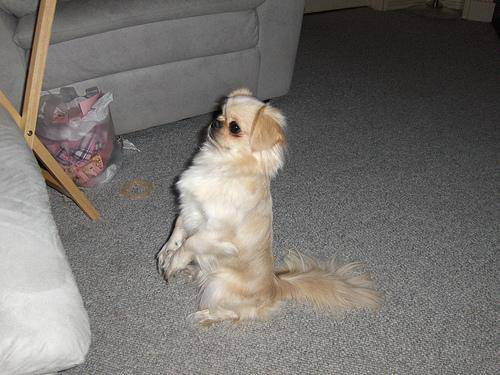

In [9]:
# Let's viev an images

from IPython.display import Image
Image('drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg')

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [10]:
filenames = ["drive/MyDrive/Dog Vision/train/"+fname + ".jpg" for fname in labels_csv['id']]

filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
#  Check whether number of filenames matches number of actual image files

import os

if len(os.listdir('drive/MyDrive/Dog Vision/train/')) == len(filenames):
  print('Filenames match actual amount of files!!! Proceed.')
else:
  print('Filenames to do no match actual amount of files,acheck the target directory.')

Filenames match actual amount of files!!! Proceed.


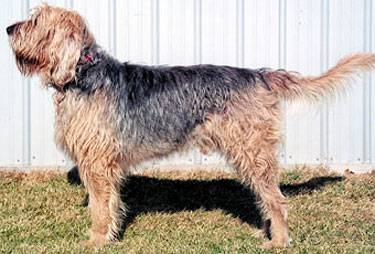

In [12]:
Image(filenames[500])

In [13]:
 labels_csv.breed[500]

'otterhound'

Since we've now got our training image filepaths in a list,let's prepare our labels

In [14]:
import numpy as np

labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels) does same thing above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print('Number of labels  matches number of filename')
else:
  print('Number of labels does not match number of filenames,check data directories')

Number of labels  matches number of filename


In [17]:
# Find the unique label values

unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
# Turn a single labl into an array og booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2] 

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds==labels[0])) # index where labell occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
print(labels[5])
print(boolean_labels[5].astype(int))

bedlington_terrier
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
filenames[:5]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

### Creating oun validation set

Since the dataset from Kaggle doesn't come with a validation set,we're going to create our own.

In [24]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increse as needed

In [25]:
# Set number of images to use for experimenting

NUM_IMAGES = 1000 #@param{type:'slider',min:1000,max:10000,step:1000}

In [26]:
# Let's split our data into train and validation sets

from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],
                                               y[:NUM_IMAGES],
                                               test_size=0.2,
                                               random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [27]:
# Let's have a geez at the training data
X_train[:3],y_train[:3]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fa

## Preprocessing Images(Turning images into Tensors)

To preprocess our images into Tensor we're going to write a function that does a few things:

1. Take an image filepath in the input
2. Use TensorFlow to read the file and save it to a variable,`image`
3. Turn our `image`(a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1 )
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

Before we,do let's see what importing an image look like.

In [28]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[40])
image.shape

(293, 400, 3)

In [29]:
image.max(),image.min()

(255, 0)

In [30]:
image[:2]

array([[[255, 246, 252],
        [254, 237, 243],
        [253, 237, 240],
        ...,
        [112, 164,  89],
        [ 99, 151,  79],
        [ 94, 146,  74]],

       [[255, 250, 248],
        [255, 251, 249],
        [255, 246, 242],
        ...,
        [ 96, 148,  74],
        [ 88, 140,  68],
        [ 90, 141,  72]]], dtype=uint8)

In [31]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 400, 3), dtype=uint8, numpy=
array([[[255, 246, 252],
        [254, 237, 243],
        [253, 237, 240],
        ...,
        [112, 164,  89],
        [ 99, 151,  79],
        [ 94, 146,  74]],

       [[255, 250, 248],
        [255, 251, 249],
        [255, 246, 242],
        ...,
        [ 96, 148,  74],
        [ 88, 140,  68],
        [ 90, 141,  72]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath in input
2. Use TensorFlow to read the file and save in to a variable,`image`
3. Turn our `image`(a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1 )
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`


More information on loading images in TensorFlow can be see here: https://www.tensorflow.org/tutorials/load_data/images

In [32]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images

def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels(R,G,B)
  image = tf.image.decode_jpeg(image,channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

## Turning our data into batches

Why turn out data into batches?

Let's say you're trying to process 10,000+ images in one go..they all might not fit into memory.

So that's why we do about 32(this is the batch size)images at a time(you can manually adjust the batch size if need be).

In order to use TensorFlow effectively,we need our data in the form of Tensor tuples which look like this:`(image, label)`

In [33]:
# Create a simple function to return a tuple(image,label)
def get_image_label(image_path,label):
  
  """
  Takes an image file path name and the associated label,
  precesses the image and returns a typle of (image,label).
  """
  image = process_image(image_path)
  return image,label

In [34]:
# Demo of above
(process_image(X[40]),y[40])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.99609005, 0.96119833, 0.95770377],
         [0.98501533, 0.94666374, 0.93379605],
         [0.99749774, 0.9770274 , 0.9565523 ],
         ...,
         [0.34569168, 0.5497533 , 0.22850783],
         [0.4276134 , 0.6322353 , 0.33483163],
         [0.36833197, 0.5772412 , 0.29097825]],
 
        [[0.9687435 , 0.965289  , 0.9172323 ],
         [0.94134724, 0.93233955, 0.8760108 ],
         [0.92182285, 0.9180851 , 0.8512452 ],
         ...,
         [0.36644298, 0.57037514, 0.24943131],
         [0.36225268, 0.5662274 , 0.2703323 ],
         [0.34930357, 0.5534058 , 0.27435333]],
 
        [[0.82989013, 0.87487435, 0.75133675],
         [0.7506709 , 0.7958162 , 0.66784185],
         [0.75523835, 0.8078179 , 0.67545015],
         ...,
         [0.40426058, 0.60512996, 0.2932135 ],
         [0.35947898, 0.55773896, 0.2682605 ],
         [0.38644102, 0.5856088 , 0.3115852 ]],
 
        ...,
 
        [[0.45484307, 0.5300532 

Now we 'vw got a way to turn our data into tuples of Tensors in the form:`(image,label)`,let's a mae a function to turn all of our data (`X` & `y`) into batches!!

In [35]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valide_data=False,test_data=False):
  """
  Creates batches of data out of image(X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is test dataset, we probebly don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle if

  elif valide_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print('Creating training data batches...')

    # Turn filepath and labels into Tensors  
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping images processor function in faster than shuffling images.
    data = data.shuffle(buffer_size=len(X))
 
    # Create (image,label) tuples (this also turn the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [36]:
# Create training and validating data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valide_data=True)

Creating training data batches...
Creating validation data batches...


In [37]:
# Check out the different attributes of our data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [38]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [39]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend. let's visualize them!!

In [40]:
import matplotlib.pyplot as plt

# Create a function for viewing in a data batch

def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their labels from a fata batch.
  """

  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots(5 rows,5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display a image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")


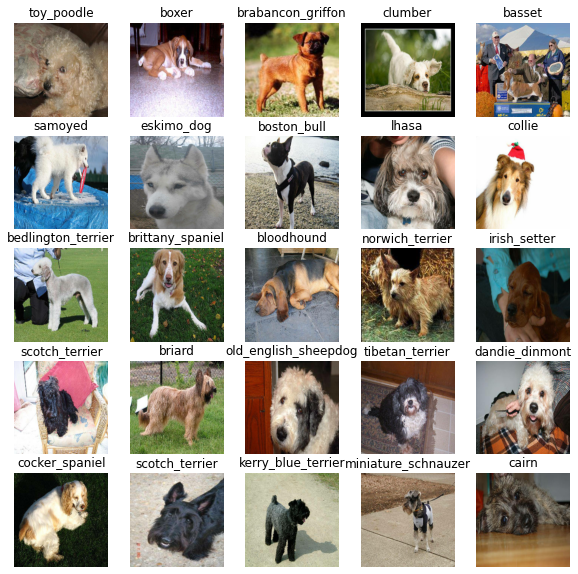

In [41]:
# Now let's visualize the data in a training batch
train_images,train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

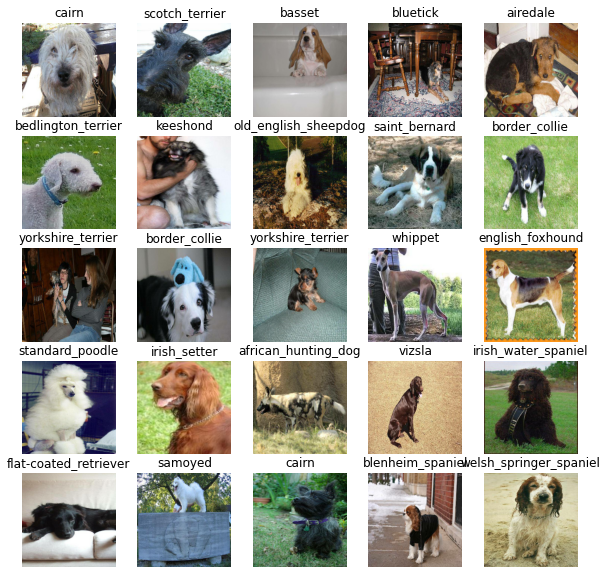

In [42]:
# Now let's visualize the data in a validation batch
val_images,val_labels = next( val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building a model

Before we build a model,there are a few things we need to define:

* The inpute shape(our images shape,in the form of Tensors) to our model.
* The output shape(image labels,in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFLow Hub - 
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5.


In [43]:
# Setup inpute shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3] # batch, height, width, color channels

# Setup output shape to the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputes, outputs and model ready to go.Let's put them together into a Keras deep learning model!!

Knowing this, let's create a function which:
* Takes the inpute shape, output shape and the model we've chosen as parametes.

* Definrs the layers in a Keras model in sequential fashion(do this first,then this,then that).

* Compiles the model(says it should be evaluated and improved).

* Building the model(Tells the model the inpute shape it'll be getting).

* Return the model.

All of these steps can be found here:https://www.tensorflow.org/guide/keras/sequential_model

In [44]:
# Crate a function which builds a Keras model

def create_model(inpute_shape=INPUT_SHAPE,output_shape = OUTPUT_SHAPE,model_url=MODEL_URL):
  print('Building model with:',MODEL_URL)

  # Setup model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (inpute layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation ='softmax') # Layer 2 (output layer) 
  ])

  # Compile the model

  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [45]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callback, one for TensorBoard which helpes track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBord Callback
To setup a TensorBoard callback, we need to do 3 things:
1. Load a TensorBoard callback which is able to save logs to a directory and pass in to our model's `fit()` function.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function(we'll do this after model training).

In [46]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [52]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join('drive/MyDrive/Dog Vision/logs',
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stoping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [48]:
# Create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [49]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [51]:
# Check to make sure we're stillrunning on a GTU
print('GPU',"available(YES!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available(YES!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it in the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return model

In [54]:
# Build a function to train and return a trained model

def train_model():
  """
  Trains a given model and return the trained version.
  """
  # Create a model
  model = create_model()

  # Crete new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing in the callback we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  # Return the fitted model
  return model

In [55]:
# Fit the model to the data

model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 541s 20s/step - loss: 5.0947 - accuracy: 0.0435 - val_loss: 3.4838 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 5s 211ms/step - loss: 1.9403 - accuracy: 0.6056 - val_loss: 2.2416 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 5s 207ms/step - loss: 0.6184 - accuracy: 0.9339 - val_loss: 1.7557 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 5s 209ms/step - loss: 0.2653 - accuracy: 0.9879 - val_loss: 1.5488 - val_accuracy: 0.6100
Epoch 5/100
25/25 [==============================] - 5s 207ms/step - loss: 0.1535 - accuracy: 0.9970 - val_loss: 1.4725 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 5s 208ms/step - loss: 0.0977 - accuracy: 0.9996 - val_loss: 1.4365 - val_accuracy: 0.6200
Epoch 7/100
25/25 [==============================

**Question:**It tooks like our model is overfitting because it's peforming far better on the training dataset than the validation dataset,what are some ways to prevent model overfitting in deep learning neural network?

**Note:**Overfitting to begin with is a good thing! It means our model is learning!!